# Bundle Adjustment SLAM in 2D

STUDENT VERSION.

Students: Please go to `File > Save a copy in Drive` before proceeding.

In [31]:
# First, install gtsam
!pip install gtsam

In [32]:
# Import standard packages
# For vectorized operations and linear algebra
import numpy as np
# For plotting
import matplotlib.pyplot as plt
# For loading in the CSV data as a proper table (i.e., dataframe)
import pandas as pd

# Import the key packages for gtsam
# The top level package
import gtsam
# As implied, the plotting tools
import gtsam.utils.plot as gtsam_plot
# Convenience methods for landmarks (L) and states (X)
# These need to be reset if defined later
from gtsam.symbol_shorthand import L, X

Now we need to load in the data. Click the folder icon at left. This is your directory. Drag the `robot_history_{num}.csv` files into the panel that appears. You will have to repeat this if you restart the Google Colab session.

In [33]:
# Load in the data as a table

# You will come back to change this at the end
### TODO (Q4.b and Q4.g) ###
robot_gt_df = pd.read_csv('robot_history_10.csv') # this is GROUND TRUTH (gt)!
###

# Data is (time), (x, y, theta), (speed, dtheta), (measurements)
n_time_steps, n_params = robot_gt_df.shape
n_landmarks = (n_params - (1 + 3 + 2)) // 2

print(f"Data contains {n_time_steps} time steps and {n_landmarks} landmarks.\n")
robot_gt_df

Data contains 11 time steps and 12 landmarks.



,# time,x,y,theta,speed,dtheta,range_0,range_1,range_2,range_3,...,bearing_2,bearing_3,bearing_4,bearing_5,bearing_6,bearing_7,bearing_8,bearing_9,bearing_10,bearing_11
0,0.0,0.0,0.0,0.000000,3.0,0.000000,1.414214,1.414214,5.099020,7.071068,...,11.309932,8.130102,NaN,NaN,NaN,NaN,29.744881,38.659808,104.036243,99.462322
1,1.0,3.0,0.0,0.000000,3.0,0.000000,4.123106,4.123106,2.236068,4.123106,...,26.565051,14.036243,8.130102,-6.340192,NaN,29.744881,45.000000,63.434949,135.000000,123.690068
2,2.0,6.0,0.0,0.000000,3.0,0.000000,7.071068,7.071068,1.414214,1.414214,...,135.000000,45.000000,14.036243,-9.462322,45.000000,45.000000,75.963757,104.036243,150.255119,139.398705
3,3.0,9.0,0.0,0.000000,3.0,1.570796,NaN,NaN,4.123106,2.236068,...,165.963757,153.434949,45.000000,-18.434949,63.434949,75.963757,116.565051,135.000000,NaN,NaN
4,4.0,12.0,0.0,1.570796,2.5,0.000000,NaN,NaN,7.071068,5.099020,...,81.869898,78.690068,63.434949,-180.000000,0.000000,26.565051,51.340192,60.255119,NaN,NaN
5,5.0,12.0,2.5,1.570796,2.5,1.570796,NaN,NaN,7.158911,5.220153,...,102.094757,106.699244,126.869898,-180.000000,0.000000,53.130102,73.300756,77.905243,NaN,NaN
6,6.0,12.0,5.0,-3.141593,3.0,0.000000,NaN,NaN,8.062258,6.403124,...,29.744881,38.659808,63.434949,90.000000,-90.000000,26.565051,11.309932,8.130102,NaN,NaN
7,7.0,9.0,5.0,-3.141593,3.0,0.000000,NaN,NaN,5.656854,4.472136,...,45.000000,63.434949,104.036243,116.565051,-161.565051,135.000000,26.565051,14.036243,NaN,NaN
8,8.0,6.0,5.0,-3.141593,3.0,0.000000,9.219544,8.062258,4.123106,4.123106,...,75.963757,104.036243,135.000000,135.000000,-170.537678,165.963757,135.000000,45.000000,8.130102,-8.130102
9,9.0,3.0,5.0,-3.141593,3.0,0.000000,7.211103,5.656854,4.472136,5.656854,...,116.565051,135.000000,150.255119,NaN,-173.659808,171.869898,165.963757,153.434949,14.036243,-14.036243


## Adding noise

The data provided is ground truth. The code below adds the required noise. You can change these, but you should put everything back to the original settings when you submit

In [34]:
## Code to roll out the trajectory

def step_robot_pose(pose_curr: np.ndarray, speed: float, delta_theta: float):
    """
    Take the speed and turn to update the 2D pose.
    """
    # Unpack the pose
    x, y, theta = pose_curr

    # Update the position
    x += speed * np.cos(theta)
    y += speed * np.sin(theta)

    # Update the angle at the END of the step
    theta += delta_theta

    # Wrap the angle to [-pi, pi]
    theta = (theta + np.pi) % (2 * np.pi) - np.pi

    # Pack the pose back up
    return np.array([x, y, theta])

def rollout_robot_pose(pose_start: np.ndarray,
                       speeds: np.ndarray,
                       delta_thetas: np.ndarray,
                       ignore_last: bool = True):
    """
    Take the starting pose and step multiple times to get a roll out from the
    starting pose.
    """
    pose_list = [pose_start]
    pose_curr = pose_start.copy()

    for speed, delta_theta in zip(speeds, delta_thetas):
        pose_curr = step_robot_pose(pose_curr, speed, delta_theta)
        pose_list.append(pose_curr)

    if ignore_last:
        pose_list.pop()

    return np.array(pose_list)

In [35]:
# Create noise models

# For the submission use noise_factor = 1, but you may find it helpful to use
# noise_factor = 1e-3 for testing your code.
noise_factor = 1

# NUMPY VERSIONS
# Feel free to change the numbers, just be sure to change them back for the
# homework submission.
# We assume "pretty good starting"
PRIOR_NOISE_NUMPY = noise_factor * np.array([0.1, 0.1, np.deg2rad(1)])
# 0.3 units in x and y, and 20 degree error in angle, perhaps from wheel encoder
ODOMETRY_NOISE_NUMPY = noise_factor * np.array([0.3, 0.3, np.deg2rad(20)])
# We assume the LIDAR measurements are a lot cleaner
# 0.01 in x and y, and 0.01 degree error in angle
MEASUREMENT_NOISE_NUMPY =  noise_factor * np.array([0.01, np.deg2rad(0.01)])

# GTSAM versions

PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(noise_factor * PRIOR_NOISE_NUMPY)
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(noise_factor * ODOMETRY_NOISE_NUMPY)
MEASUREMENT_NOISE = gtsam.noiseModel.Diagonal.Sigmas(noise_factor * MEASUREMENT_NOISE_NUMPY)

In [36]:
# Make a dataframe but with the noisy data
robot_noisy_df = robot_gt_df.copy()

# The random seed is for sanity, to make sure you can run the notebook again
# and get the exact same plots.
np.random.seed(273)
robot_noisy_df["speed"] += np.random.normal(0, ODOMETRY_NOISE_NUMPY[0], n_time_steps)
robot_noisy_df["dtheta"] += np.random.normal(0, ODOMETRY_NOISE_NUMPY[-1], n_time_steps)

# again, we are using "near-perfect initialization" or "relative to initialization"
# So, no noise is added to the initial pose
inital_pose = robot_gt_df[["x", "y", "theta"]].iloc[0].to_numpy()
robot_noisy_df[["x", "y", "theta"]] = rollout_robot_pose(
    inital_pose, robot_noisy_df["speed"], robot_noisy_df["dtheta"])

# add noise to the measurements
# Loop through the landmarks for range and bearing
for l_ind in range(n_landmarks):
    robot_gt_df[f"range_{l_ind}"] += np.random.normal(0, MEASUREMENT_NOISE_NUMPY[0], n_time_steps)
    robot_gt_df[f"bearing_{l_ind}"] += np.random.normal(0, MEASUREMENT_NOISE_NUMPY[1], n_time_steps)

robot_noisy_df

,# time,x,y,theta,speed,dtheta,range_0,range_1,range_2,range_3,...,bearing_2,bearing_3,bearing_4,bearing_5,bearing_6,bearing_7,bearing_8,bearing_9,bearing_10,bearing_11
0,0.0,0.000000,0.000000,0.000000,3.254924,-0.070605,1.414214,1.414214,5.099020,7.071068,...,11.309932,8.130102,NaN,NaN,NaN,NaN,29.744881,38.659808,104.036243,99.462322
1,1.0,3.254924,0.000000,-0.070605,3.008145,-0.210278,4.123106,4.123106,2.236068,4.123106,...,26.565051,14.036243,8.130102,-6.340192,NaN,29.744881,45.000000,63.434949,135.000000,123.690068
2,2.0,6.255575,-0.212213,-0.280883,3.222176,0.330512,7.071068,7.071068,1.414214,1.414214,...,135.000000,45.000000,14.036243,-9.462322,45.000000,45.000000,75.963757,104.036243,150.255119,139.398705
3,3.0,9.351478,-1.105413,0.049630,3.310150,2.089231,NaN,NaN,4.123106,2.236068,...,165.963757,153.434949,45.000000,-18.434949,63.434949,75.963757,116.565051,135.000000,NaN,NaN
4,4.0,12.657552,-0.941200,2.138860,2.482692,-0.335601,NaN,NaN,7.071068,5.099020,...,81.869898,78.690068,63.434949,-180.000000,0.000000,26.565051,51.340192,60.255119,NaN,NaN
5,5.0,11.321861,1.151571,1.803259,2.678351,1.677509,NaN,NaN,7.158911,5.220153,...,102.094757,106.699244,126.869898,-180.000000,0.000000,53.130102,73.300756,77.905243,NaN,NaN
6,6.0,10.704836,3.757880,-2.802417,3.001207,-0.221030,NaN,NaN,8.062258,6.403124,...,29.744881,38.659808,63.434949,90.000000,-90.000000,26.565051,11.309932,8.130102,NaN,NaN
7,7.0,7.874610,2.759347,-3.023447,2.853366,0.082388,NaN,NaN,5.656854,4.472136,...,45.000000,63.434949,104.036243,116.565051,-161.565051,135.000000,26.565051,14.036243,NaN,NaN
8,8.0,5.041135,2.423018,-2.941059,2.969787,-0.219678,9.219544,8.062258,4.123106,4.123106,...,75.963757,104.036243,135.000000,135.000000,-170.537678,165.963757,135.000000,45.000000,8.130102,-8.130102
9,9.0,2.130861,1.831459,3.122448,2.694623,0.190524,7.211103,5.656854,4.472136,5.656854,...,116.565051,135.000000,150.255119,NaN,-173.659808,171.869898,165.963757,153.434949,14.036243,-14.036243


## (Q4.b-c) Building the factor graph

In [131]:
# Re-import here so that you can rerun this cell to debug without rerunning
# everything
from gtsam.symbol_shorthand import L, X

# Create an empty nonlinear factor graph
### TODO (Q4.b) ###
graph = gtsam.NonlinearFactorGraph()
###

Xs = [X(i) for i in range(n_time_steps)]
Ls = [L(i) for i in range(n_landmarks)]
# print(np.array(Xs).shape[0])
# print(np.array(Ls).shape[0])

# Add a prior factor at the origin to set the origin of the SLAM problem
### TODO (Q4.b) ###
# 1. A prior factor consists of a mean and a noise model (covariance matrix)
X_start = Xs[0]
pose = gtsam.Pose2(0, 0, 0) # (x,y,theta)->origin & zero angle
graph.add(gtsam.PriorFactorPose2(X_start, pose, PRIOR_NOISE))
###

# Loop through the noisy data (i.e., `robot_noisy_df`)
# In the loop,
#    get the relative motion with pose_{i} - pose_{i - 1}
#    the measurements are in the noisy data
# Don't forget the loop closure constraint

### TODO (Q4.c) ####
for i in range(len(Xs)):
    # Odometry (odo factor)
    if i != 0:
        X_prev = Xs[i - 1]
        X_curr = Xs[i]
        # print(f'X prev {X_prev}, X_curr {X_curr}')
        prev_pose = gtsam.Pose2(robot_noisy_df.x[i-1],robot_noisy_df.y[i-1],robot_noisy_df.theta[i-1])
        curr_pose = gtsam.Pose2(robot_noisy_df.x[i],robot_noisy_df.y[i],robot_noisy_df.theta[i])
        rel_pose = prev_pose.between(curr_pose)
        graph.add(gtsam.BetweenFactorPose2(X_prev, X_curr, rel_pose, ODOMETRY_NOISE)) ##


    # Landmark (sensor factor)
    for j in range(len(Ls)):
        L_curr = Ls[j]
        bearing_col = f'bearing_{j}'
        range_col = f'range_{j}'
        # Check if bearing and range values are not NaN (Only add factor where there is a value)
        if pd.notna(robot_noisy_df[bearing_col].iloc[i]) and pd.notna(robot_noisy_df[range_col].iloc[i]):
            Bearing = gtsam.Rot2.fromDegrees(robot_noisy_df[bearing_col].iloc[i])
            Range = robot_noisy_df[range_col].iloc[i]
            graph.add(gtsam.BearingRangeFactor2D(Xs[i], L_curr, Bearing, Range, MEASUREMENT_NOISE)) ##

# loop closure constraint (between 2nd and 8th)
pose_offset = gtsam.Pose2(0, 5, np.deg2rad(180))
graph.add(gtsam.BetweenFactorPose2(Xs[2], Xs[8], pose_offset, ODOMETRY_NOISE)) ##

# Print the factor graph to see all the nodes
### TODO (Q4.c) ####
graph.print("\nFactor Graph:\n")  # print
###


Factor Graph:
size: 114

Factor 0: PriorFactor on x0
  prior mean:  (0, 0, 0)
  noise model: diagonal sigmas [0.1; 0.1; 0.0174532925];

Factor 1: BearingRangeFactor
Factor 1:   keys = { x0 l0 }
  noise model: diagonal sigmas [0.01; 0.000174532925];
ExpressionFactor with measurement: bearing : -2.35619449
range  1.41421356

Factor 2: BearingRangeFactor
Factor 2:   keys = { x0 l1 }
  noise model: diagonal sigmas [0.01; 0.000174532925];
ExpressionFactor with measurement: bearing : 2.35619449
range  1.41421356

Factor 3: BearingRangeFactor
Factor 3:   keys = { x0 l2 }
  noise model: diagonal sigmas [0.01; 0.000174532925];
ExpressionFactor with measurement: bearing : 0.19739556
range  5.09901951

Factor 4: BearingRangeFactor
Factor 4:   keys = { x0 l3 }
  noise model: diagonal sigmas [0.01; 0.000174532925];
ExpressionFactor with measurement: bearing : 0.141897055
range  7.07106781

Factor 5: BearingRangeFactor
Factor 5:   keys = { x0 l8 }
  noise model: diagonal sigmas [0.01; 0.00017453292

## (Q4.d) Initialize the optimization problem

In [132]:
# Set-up a values data structure for the initial estimate
### TODO (Q4.d) ###
initial_estimate = gtsam.Values() # placeholder structure
###

# Set the initial poses from the noisy odometry alone
# Hint, you already have this in `robot_noisy_df`
### TODO (Q4.d) ###
# 1. Initial estimate - pose
for i in range(len(Xs)):
    X_curr = Xs[i]
    pose = gtsam.Pose2(robot_noisy_df.x[i],robot_noisy_df.y[i],robot_noisy_df.theta[i])
    initial_estimate.insert(X_curr, pose) ##
###

# Sample random values for the initial landmark positions
# In reality, you would have to estimate these from odometry,
# but to not over-complicate the problem, just use noisy
# ground-truth.
# In reality, the initialization is very important for the
# graph optimization to converge to a good solution!!
l_init_vec = [
    (-1, -1),
    (-1, 1),
    (5, 1),
    (7, 1),
    (10, 1),
    (12, -1),
    (12, 6),
    (10, 4),
    (7, 4),
    (5, 4),
    (-1, 4),
    (-1, 6)
]

for l_ind, L in enumerate(Ls):
    l_hat = l_init_vec[l_ind]
    point_init = (np.random.normal(l_hat[0], ODOMETRY_NOISE_NUMPY[0]),
                  np.random.normal(l_hat[1], ODOMETRY_NOISE_NUMPY[0]))
    # Add the initial estimates of the landmarks
    ### TODO (Q4.d) ###
    initial_estimate.insert(L, gtsam.Point2(point_init[0], point_init[1])) ##
    ###

# Print the initial estimates to verify
### TODO (Q4.d) ###
initial_estimate.print("\n initial_estimate:\n")  # print
###


 initial_estimate:

Values with 23 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.31608044;
	-1.05125859
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-0.833663915;
	0.955761859
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	5.24437982;
	0.824327082
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	7.51739622;
	1.38987038
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.96715336;
	1.38239328
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	11.7164265;
	-1.48985876
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	11.8989729;
	5.76211008
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.53642407;
	3.68466277
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	6.74881991;
	4.47718192
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	4.57009863;
	4.38910495
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.0259122;
	3.81670987
]

Value l11: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1

[-1.31608044 -1.05125859]
[-0.83366392  0.95576186]
[5.24437982 0.82432708]
[7.51739622 1.38987038]
[9.96715336 1.38239328]
[11.71642648 -1.48985876]
[11.89897285  5.76211008]
[9.53642407 3.68466277]
[6.74881991 4.47718192]
[4.57009863 4.38910495]
[-1.0259122   3.81670987]
[-1.4121789   6.46975035]


<Figure size 640x480 with 0 Axes>

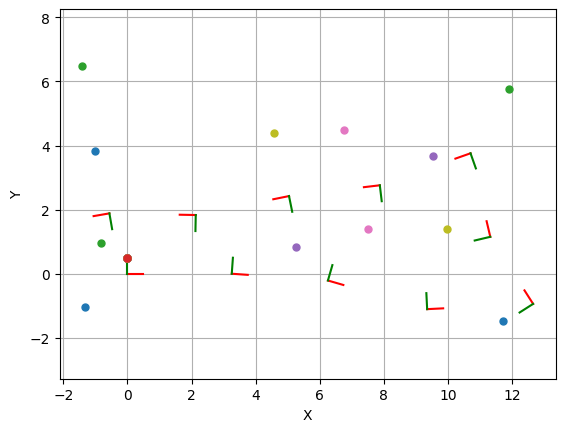

In [133]:
# Plot the initial poses and landmarks.
# For example, for poses, the code is
# gtsam_plot.plot_pose2(
#         fignum: int,
#         pose: Pose2,
#         axis_length: float = 0.1,
#         covariance: np.ndarray = None,
#         axis_labels=("X axis", "Y axis", "Z axis"),
# )
# We do need covariance for this part. The source code is here:
# https://github.com/borglab/gtsam/blob/develop/python/gtsam/utils/plot.py

# Don't forget to use axis equals!


### TODO (Q4.d) ###
# Plot the initial poses and landmarks
plt.figure()
fignum = 0
# Plot poses
for i in range(len(Xs)):
    pose = initial_estimate.atPose2(Xs[i])
    gtsam_plot.plot_pose2(fignum, pose, 0.5)

# Plot landmarks
for L in Ls:
    point = initial_estimate.atPoint2(L)
    gtsam_plot.plot_point2(fignum, point, 0.5)
    print(point)

plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axis('equal')
plt.show()
###

## (Q4.e) Graph Optimization

In [134]:
# We are going to optimize with the Levenberg-Marquardt solver.
# You can definitely consider other options (e.g., Gauss Newton).
# You may be interested in AA 222: Optimization for more about these
# methods. Levenberg-Marquardt has a number of configuration
# parameters, but we will use the defaults. For your projects, you
# might consider tweaking the parameters for tighter convergence.

lm_params = gtsam.LevenbergMarquardtParams()

# Fill the optimizer with your graph and initial estimates (in that
# order).
### TODO (Q4.e) ###
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, lm_params)
result = optimizer.optimize()
###

# Print the results
### TODO (Q4.e) ###
print(result)
###

Values with 23 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-0.999999728;
	-1.00000026
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.00000023;
	0.999999751
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	4.99999977;
	1.00000125
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	6.99999978;
	1.00000176
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.99999977;
	1.00000253
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	12.0000003;
	-0.999996954
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	11.9999985;
	6.00000304
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.99999901;
	4.00000253
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	6.99999901;
	4.00000176
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	4.99999901;
	4.00000125
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.00000098;
	3.99999975
]

Value l11: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.00000149;
	5.999999

In [135]:
# To understand uncertainty, you need the marginal Gaussian distributions.
# gtsam makes this directly accessible with
# marginals = gtsam.Marginals(graph, result)
# The covariance matrices are in marginals. For example, the covariance
# matrix for X(1) (i.e., Xs[0]) is
# marginals.marginalCovariance(X(1))

# Check that you can print the marginal covariance matrices for both poses
# and landmarks
### TODO (Q4.e) ###
marginals = gtsam.Marginals(graph, result)

# 1. Cov for pose
# for X in Xs:
  # print(marginals.marginalCovariance(X))

# 2. Cov for landmarks
# for L in Ls:
#   print(marginals.marginalCovariance(L))
###


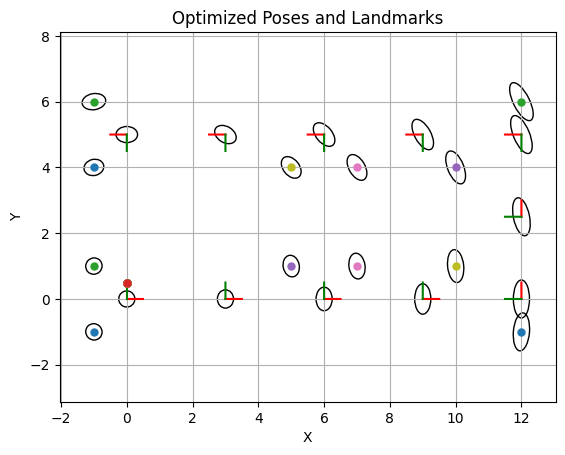

In [136]:
# Now plot the poses and landmarks _with_ covariance ellipses.
### TODO (Q4.e) ###
plt.figure()
fignum = 1

# Plot poses
for X in Xs:
    pose = result.atPose2(X)
    cov_pose = marginals.marginalCovariance(X)
    gtsam_plot.plot_pose2(fignum, pose, 0.5, covariance=cov_pose)

# Plot landmarks
for L in Ls:
    point = result.atPoint2(L)
    cov_point = marginals.marginalCovariance(L)
    gtsam_plot.plot_point2(fignum, point, 0.5, P = cov_point)

plt.title('Optimized Poses and Landmarks')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axis('equal')
plt.show()
###

# You may find if helpful to plot line segments connecting poses at
# adjacent time steps to understand what is happening.
# For a given `pose`, use `pose.translation()` to get the translation
# term (i.e., the position)
### TODO (Q4.h) ###

###